# Probability To Fail

One of the key performance indicators that we would like to create greater visibility into and for a given moment in time, is to calculate what is the probability that a given test will fail. Using this information, we plan to build a model that uses the probability to fail to predict the time to failure. 

In order to provide maxium flexibility for the end-user of this work, instead of creating a number of dataframes to answer each of these specifc questions, we will define a long and narrow data structure (a list of tuples saved as a csv for now) that contains only 7 columns ("timestamp", "tab","grid","test","test_duration", "pass_or_fail", "prob"). This allows visualization tools like Superset (or pandas) to perform the last filter and/or aggregate interested columns to an end user. Which is to say, there may be a lot of repetition within the final data set, but each row should be unique, and it should provide the simplest usability for an end-user. 

Linked issue(s) : [Issue](https://github.com/aicoe-aiops/ocp-ci-analysis/issues/282)

In [1]:
import json
import gzip
import os
import pandas as pd
import datetime
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss, roc_auc_score
from matplotlib import pyplot
import numpy as np

from ipynb.fs.defs.metric_template import testgrid_labelwise_encoding
from ipynb.fs.defs.metric_template import CephCommunication
from ipynb.fs.defs.metric_template import save_to_disk, read_from_disk
from dotenv import load_dotenv, find_dotenv
import warnings

warnings.filterwarnings("ignore")

load_dotenv(find_dotenv())

True

In [2]:
## Specify variables
METRIC_NAME = "probability_to_fail"
# Specify the path for input grid data,
INPUT_DATA_PATH = "../../../../data/raw/testgrid_183.json.gz"

# Specify the path for output metric data
OUTPUT_DATA_PATH = f"../../../../data/processed/metrics/{METRIC_NAME}"

# Specify whether or not we are running this as a notebook or part of an automation pipeline.
AUTOMATION = os.getenv("IN_AUTOMATION")

## CEPH Bucket variables
## Create a .env file on your local with the correct configs,
s3_endpoint_url = os.getenv("S3_ENDPOINT")
s3_access_key = os.getenv("S3_ACCESS_KEY")
s3_secret_key = os.getenv("S3_SECRET_KEY")
s3_bucket = os.getenv("S3_BUCKET")
s3_input_data_path = "raw_data"
metric_path = f"metrics/{METRIC_NAME}"

In [3]:
## Import data
timestamp = datetime.datetime.today()

if AUTOMATION:
    filename = f"testgrid_{timestamp.day}{timestamp.month}.json"
    cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
    s3_object = cc.s3_resource.Object(s3_bucket, f"{s3_input_data_path}/{filename}")
    file_content = s3_object.get()["Body"].read().decode("utf-8")
    testgrid_data = json.loads(file_content)

else:
    with gzip.open(INPUT_DATA_PATH, "rb") as read_file:
        testgrid_data = json.load(read_file)

## Calculation

In [4]:
# We will now fetch all the tests which are failing i.e. have a status code of 12.
failures_list = testgrid_labelwise_encoding(testgrid_data, 12, overall_only=False)

In [5]:
# Convert to dataframe
failures_df = pd.DataFrame(
    failures_list,
    columns=["timestamp", "tab", "grid", "test", "test_duration", "failure"],
)
failures_df.head()

,timestamp,tab,grid,test,test_duration,failure
0,2021-03-15 23:40:20,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,80.283333,False
1,2021-03-15 00:01:06,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,92.050000,False
2,2021-03-13 20:51:32,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,80.983333,False
3,2021-03-13 07:51:20,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,117.716667,False
4,2021-03-13 06:43:20,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,108.633333,False


In [6]:
# We will fetch all the tests which are passing i.e. have status code of 1.
passing_list = testgrid_labelwise_encoding(testgrid_data, 1, overall_only=False)

In [7]:
# Convert to dataframe
passing_df = pd.DataFrame(
    passing_list,
    columns=["timestamp", "tab", "grid", "test", "test_duration", "passing"],
)
passing_df.head()

,timestamp,tab,grid,test,test_duration,passing
0,2021-03-15 23:40:20,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,80.283333,True
1,2021-03-15 00:01:06,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,92.050000,True
2,2021-03-13 20:51:32,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,80.983333,True
3,2021-03-13 07:51:20,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,117.716667,True
4,2021-03-13 06:43:20,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,108.633333,True


In [8]:
df = pd.merge(
    failures_df,
    passing_df,
    on=["timestamp", "tab", "grid", "test", "test_duration"],
)
df = df.dropna()
df.head()

,timestamp,tab,grid,test,test_duration,failure,passing
0,2021-03-15 23:40:20,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,80.283333,False,True
1,2021-03-15 00:01:06,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,92.050000,False,True
2,2021-03-13 20:51:32,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,80.983333,False,True
3,2021-03-13 07:51:20,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,117.716667,False,True
4,2021-03-13 06:43:20,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,108.633333,False,True


In [9]:
df.shape

(8023876, 7)

### Calculate Probability to Fail using SVM and Calibrated Classification Model

In order to calculate the probability to fail, some of the approaches we could consider are SVM (support vector machines) and a Calibrated Classification Model. In this section of the notebook, we will compare the SVM and Calibrated Classification model, and choose the model giving better results.

The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points. SVM is a good candidate model to calibrate because it does not natively predict probabilities, meaning the probabilities are often uncalibrated. The probabilities are not normalized, but can be normalized when calling the `calibration_curve()` function by setting the `normalize` argument to `True`.

An SVM model can be created using the [scikit learn module](https://scikit-learn.org/stable/modules/svm.html).

A classification predictive modeling problem requires predicting or forecasting a label for a given observation. An alternative to predicting the label directly, a model may predict the probability of an observation belonging to each possible class label. Although a model may be able to predict probabilities, the distribution and behavior of the probabilities may not match the expected distribution of observed probabilities in the training data. The distribution of the probabilities can be adjusted to better match the expected distribution observed in the data. This adjustment is referred to as calibration, as in the calibration of the model or the calibration of the distribution of class probabilities.

A classifier can be calibrated using the [CalibratedClassifierCV](http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html) sci-kit library. We will generate the labels/classes required for classification and train the model on a subset of the data set.

In [10]:
## This helper function will add pass/fail labels to enable classification model
## i.e 1-"Pass", 0-"Failure".
def p_f_label(row):
    if row["passing"]:
        return 1
    elif row["failure"]:
        return 0

In [11]:
## Create a sample df with a batch of 100000 to start with.
sample_df = df[0:100000]
## Add the pass_or_fail label using the helper function `p_f_label`
sample_df["pass_or_fail"] = sample_df.apply(lambda row: p_f_label(row), axis=1)

In [12]:
## For all the missing test_duration values, drop the row.
sample_df = sample_df.dropna()
## Labels for multiclass classification
sample_df.pass_or_fail.unique()
sample_df.pass_or_fail.value_counts()

1.0    94142
0.0     3176
Name: pass_or_fail, dtype: int64

#### SVM
Now, we will fit the SVM model to calculate the probabilities.

In [13]:
## Create X = test_duration and y = pass_or_fail and calculate probabilty.
X, y = np.array([sample_df["test_duration"].values]), np.array(
    [sample_df["pass_or_fail"].values]
)
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

# split into train/test sets.
trainx, testx, trainy, testy = train_test_split(
    X, y, train_size=0.8, test_size=0.2, random_state=42
)

# fit a SVM Model.
model = SVC(probability=True).fit(trainx, trainy)

# Evaluate the model
y_pred = model.predict(testx)

# predict probabilities.
probs_train = model.predict_proba(trainx)[:, 0]
probs_test = model.predict_proba(testx)[:, 0]
probs = np.append(probs_train, probs_test, axis=None)
sample_df["prob"] = probs

*NOTE* : The probabilities are not normalized, but can be normalized when calling the `calibration_curve()` function by setting the `normalize` argument to `True`.

In [14]:
# Mean accuracy on the given test data and labels.
svm_accuracy = model.score(testx, testy)
print("SVM Model accuracy :", svm_accuracy)
svm_brier = brier_score_loss(testy, y_pred, pos_label=1)
print("SVM Brier Score", svm_brier)
svm_roc = roc_auc_score(testy, y_pred)
print("SVM Roc Score", svm_roc)

SVM Model accuracy : 0.9714344430743937
SVM Brier Score 0.028565556925606247
SVM Roc Score 0.5397350993377483


Brier Score is a distance in the probability domain. Which means: the lower the value of this score, the better the prediction. 

The above calculated score is a harsh metric since we require for each sample that each label set be correctly predicted. This does not give us a clear indication of a better model so we will use the reliability diagram to find out the better suited model.

##### Reliability Diagram

A reliability diagram is a line plot of the relative frequency of what was observed (y-axis) versus the predicted probability frequency  (x-axis). These plots are commonly referred to as ‘reliability‘ diagrams in forecast literature, although may also be called ‘calibration‘ plots or curves as they summarize how well the forecast probabilities are calibrated.

The better calibrated or more reliable a forecast, the closer the points will appear along the main diagonal from the bottom left to the top right of the plot.

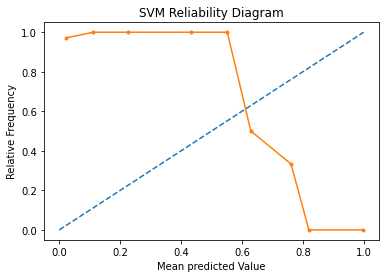

In [15]:
# reliability diagram
fop, mpv = calibration_curve(testy, probs_test, n_bins=10, normalize=True)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle="--")
# plot model reliability
pyplot.plot(mpv, fop, marker=".")
pyplot.xlabel("Mean predicted Value")
pyplot.ylabel("Relative Frequency")
pyplot.title("SVM Reliability Diagram")
pyplot.show()

In the above graph, the solid line represents the calibration of the SVMs predicted probabilities and the dotted line represents a comparison to a perfectly calibrated model. The better calibrated or more reliable a forecast, the closer the points will appear along the main diagonal from the bottom left to the top right of the plot. Here, we see that calibration probabilities are much further away from the ideal prediction.

The position of the points or the curve relative to the diagonal can help to interpret the probabilities; for example:

* *Below the diagonal*: The model has over-forecast; the probabilities are too large.
* *Above the diagonal*: The model has under-forecast; the probabilities are too small.

Since this graph indicates that the probabilities calculated by SVM are too small, we shall move forward and look in the Calibrated Classification Model.

#### Calibrated Classification Model

 - CalibratedClassifierCV class using 5-fold cross-validation, to calibrate the predicted probabilities.

In [16]:
## Create X = test_duration and y = pass_or_fail and calculate probabilty.
X, y = np.array([sample_df["test_duration"].values]), np.array(
    [sample_df["pass_or_fail"].values]
)
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

# split into train/test sets.
trainx, testx, trainy, testy = train_test_split(
    X, y, train_size=0.8, test_size=0.2, random_state=42
)

# fit a Calibrated Classification Model.
model = SVC(probability=False)
calibrated = CalibratedClassifierCV(model, method="isotonic", cv=5)
calibrated.fit(trainx, trainy)

# Evaluate model
y_pred = calibrated.predict(testx)

# predict probabilities.
probs_train = calibrated.predict_proba(trainx)[:, 0]
probs_test = calibrated.predict_proba(testx)[:, 0]
probs = np.append(probs_train, probs_test, axis=None)
sample_df["prob"] = probs

*NOTE* : The probabilities are not normalized, but can be normalized when calling the `calibration_curve()` function by setting the `normalize` argument to `True`.

In [17]:
# Mean accuracy on the given test data and labels.
cc_accuracy = calibrated.score(testx, testy)
print("CCM Model accuracy :", cc_accuracy)
cc_brier = brier_score_loss(testy, y_pred, pos_label=1)
print("CCM Brier Score", cc_brier)
cc_roc = roc_auc_score(testy, y_pred)
print("CCM Roc Score", cc_roc)

CCM Model accuracy : 0.9714858199753391
CCM Brier Score 0.028514180024660912
CCM Roc Score 0.5453707345164439


Brier Score is a distance in the probability domain. Which means: the lower the value of this score, the better the prediction. 

The above calculated score is a harsh metric since we require for each sample that each label set be correctly predicted. This does not give us a clear indication of a better model so we will use the reliability diagram to find out the better suited model.

##### Reliability Diagram
A reliability diagram is a line plot of the relative frequency of what was observed (y-axis) versus the predicted probability frequency  (x-axis). These plots are commonly referred to as ‘reliability‘ diagrams in forecast literature, although may also be called ‘calibration‘ plots or curves as they summarize how well the forecast probabilities are calibrated.

The better calibrated or more reliable a forecast, the closer the points will appear along the main diagonal from the bottom left to the top right of the plot.

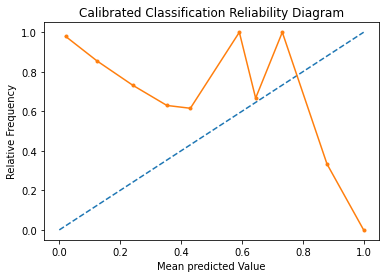

In [18]:
# reliability diagram
fop, mpv = calibration_curve(testy, probs_test, n_bins=10, normalize=True)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle="--")
# plot model reliability
pyplot.plot(mpv, fop, marker=".")
pyplot.xlabel("Mean predicted Value")
pyplot.ylabel("Relative Frequency")
pyplot.title("Calibrated Classification Reliability Diagram")
pyplot.show()

Here, we see that the shape of the calibrated probabilities is different, hugging the diagonal line much better, although still under-forecasting and over-forecasting i.e. the solid line is both above and below the ideal model.

Visually, the plot suggests a better calibrated model.

In [19]:
## Store only the valuable columns.
combined_df = sample_df[["timestamp", "tab", "grid", "test", "prob"]]

We now have the probabilities for each test likely to fail stored in the column `prob`.

## Save results to Ceph or locally
* Use the following helper function to save the data frame in a parquet format on the Ceph bucket if we are running in automation, and locally if not.

In [20]:
timestamp = datetime.datetime.now()

if AUTOMATION:
    cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
    cc.upload_to_ceph(
        combined_df.head(1000000),
        "s3_path",
        f"{METRIC_NAME}/{METRIC_NAME}-{timestamp.year}-{timestamp.month}-{timestamp.day}.parquet",
    )
else:
    save_to_disk(
        combined_df.head(1000000),
        OUTPUT_DATA_PATH,
        f"{METRIC_NAME}-{timestamp.year}-{timestamp.month}-{timestamp.day}.parquet",
    )

In [21]:
## Sanity check to see if the dataset is the same
if AUTOMATION:
    sanity_check = cc.read_from_ceph(
        "s3_path",
        f"{METRIC_NAME}/{METRIC_NAME}-{timestamp.year}-{timestamp.month}-{timestamp.day}.parquet",
    )
else:
    sanity_check = read_from_disk(
        OUTPUT_DATA_PATH,
        f"{METRIC_NAME}-{timestamp.year}-{timestamp.month}-{timestamp.day}.parquet",
    )

sanity_check

,timestamp,tab,grid,test,prob
0,2021-03-15 23:40:20,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,0.019579
1,2021-03-15 00:01:06,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,0.019579
2,2021-03-13 20:51:32,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,0.019579
3,2021-03-13 07:51:20,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,0.019579
4,2021-03-13 06:43:20,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,0.019579
...,...,...,...,...,...
1959889,2021-03-08 05:10:00,"""redhat-openshift-ocp-release-4.2-blocking""",release-openshift-origin-installer-e2e-aws-4.2,openshift-tests.[Suite:openshift/oauth/htpassw...,0.019579
1959890,2021-03-07 17:09:02,"""redhat-openshift-ocp-release-4.2-blocking""",release-openshift-origin-installer-e2e-aws-4.2,openshift-tests.[Suite:openshift/oauth/htpassw...,0.019579
1959891,2021-03-07 05:07:59,"""redhat-openshift-ocp-release-4.2-blocking""",release-openshift-origin-installer-e2e-aws-4.2,openshift-tests.[Suite:openshift/oauth/htpassw...,0.019579
1959892,2021-03-06 17:07:53,"""redhat-openshift-ocp-release-4.2-blocking""",release-openshift-origin-installer-e2e-aws-4.2,openshift-tests.[Suite:openshift/oauth/htpassw...,0.049684


## Conclusion : 

In this notebook, we calculated for a given moment in time, what is the probability that a test will fail. Using this information, we plan to build a model that uses the probability to fail value to predict the time to failure, that is how many days, weeks, months, hours, minutes or seconds do you have until the test in question stops working. As next steps, we plan to work on this [issue](https://github.com/aicoe-aiops/ocp-ci-analysis/issues/226).